### 1）图片数据的预处理

In [118]:
#导入常用的安装包，确保安装好opencv, keras
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [97]:
#1）获得图片路径名称 + 标签
#路径里面不要有中文，伤不起啊！要养成习惯
TRAIN_DIR = '/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/'
TEST_DIR = '/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/'

#train中的dogs, cats
train_dogs = [(TRAIN_DIR+i, 1) for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [(TRAIN_DIR+i, 0) for i in os.listdir(TRAIN_DIR) if 'cat' in i]

#合成训练集数据
train_images = train_dogs + train_cats

#test中的数据
test_images = [(TEST_DIR+i, -1) for i in os.listdir(TEST_DIR)]

#打乱训练集中的数据
random.shuffle(train_images)


#这里其实要学习如何分批次读取数据，保护内存不爆，一会再试试

In [98]:
#train_dogs
train_cats
#test_images

[('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3749.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3748.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3713.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3707.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3706.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3712.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3704.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3710.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3738.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3739.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3711.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3705.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/trai

In [99]:
train_images

[('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3746.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3733.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3717.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3704.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4050.jpg', 1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4009.jpg', 1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4041.jpg', 1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3736.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4037.jpg', 1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3702.jpg', 0),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4032.jpg', 1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4026.jpg', 1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/trai

In [100]:
test_images

[('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/48.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/49.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/8.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/9.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/14.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/28.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/29.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/15.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/17.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/16.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/12.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/13.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/39.jpg', -1),
 ('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_

In [101]:
#2) 把所有的图片resize进64*64
ROWS = 64
COLS = 64

def read_image(tuple_set):
    file_path = tuple_set[0]
    label = tuple_set[1]
    #print(file_path)
    #print(label)
    #Opencv图像的读取、显示和保存：https://blog.csdn.net/djcxym/article/details/52097812
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #读取图片 cv2.imread(filepath,flags)
    
    #img.all()
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC), label
#已解决错误：【python】error: (-215) ssize.width > 0 && ssize.height > 0 in function cv::resize：https://blog.csdn.net/qq_30214939/article/details/77432167
#SHIT,这个错误的原因是因为我刚没有把dogs+cats的数据合并起来，导致输入的图片都路径不对，导致imread()没有读取图片，返回None，我去！

In [114]:
#3) 把图片数据变换为容易使用的numpy数组
CHANNELS = 3
def prep_data(images):
    no_images = len(images)
    print(no_images) #长度为102
    #ndarray对象属性:https://blog.csdn.net/scorpion_zs/article/details/52526310
    data = np.ndarray((no_images, CHANNELS, ROWS, COLS), dtype=np.uint8)
    labels = []
    for i, image_file in enumerate(images):
        print('*********')
        print(i)
        print(image_file)
        print('#########')
        image, label = read_image(image_file)
        data[i] = image.T
        labels.append(label)
    return data, labels

In [115]:
#成功的把图片路径输入，得到所有图片的已经resize后的array数组格式，和对应的label值
x_train, y_train = prep_data(train_images)

102
*********
0
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3746.jpg', 0)
#########
*********
1
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3733.jpg', 0)
#########
*********
2
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3717.jpg', 0)
#########
*********
3
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3704.jpg', 0)
#########
*********
4
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4050.jpg', 1)
#########
*********
5
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4009.jpg', 1)
#########
*********
6
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4041.jpg', 1)
#########
*********
7
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3736.jpg', 0)
#########
*********
8
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/dog.4037.jpg', 1)
#########
*********
9
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/train_small/cat.3702.jpg', 0)
#########
******

In [116]:
#展示一下返回的data， label长啥样子
# [[[[111 111 111 ... 198 180 181]
#    [110 110 108 ... 187 186 169]
#    [109 109 108 ... 197 153 173]
#    ...
#    [160 159 161 ... 169 165 177]
#    [158 159 159 ... 165 173 187]
#    [157 159 158 ... 155 142 175]]

#   [[112 113 115 ... 202 184 189]
#    [113 112 109 ... 194 193 176]
#    [112 112 111 ... 201 157 179]
#    ...
#    [158 157 159 ... 180 176 186]
#    [156 157 157 ... 176 184 194]
#    [155 157 156 ... 166 153 183]]
#  这里省略了很多

#看下label结果
# [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]



In [117]:
x_test, y_shit = prep_data(test_images)

50
*********
0
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/48.jpg', -1)
#########
*********
1
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/49.jpg', -1)
#########
*********
2
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/8.jpg', -1)
#########
*********
3
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/9.jpg', -1)
#########
*********
4
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/14.jpg', -1)
#########
*********
5
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/28.jpg', -1)
#########
*********
6
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/29.jpg', -1)
#########
*********
7
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/15.jpg', -1)
#########
*********
8
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/17.jpg', -1)
#########
*********
9
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_samll/16.jpg', -1)
#########
*********
10
('/Users/a1/Desktop/learning/kaggel_06/cat_dog/test_saml

In [108]:
print(x_train.shape)
print(x_test.shape)

(102, 3, 64, 64)
(50, 3, 64, 64)


### 2) CNN模型构造

In [126]:
#这里有个报错提示:ValueError: Negative dimension size caused by subtracting 2 from 1 for 'MaxPool_1' (op: 'MaxPool') w，需要添加下面两行代码：https://blog.csdn.net/w5688414/article/details/78780440
from keras import backend as K
K.set_image_dim_ordering('th')

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

# 建造模型    
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

/Users/a1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/Users/a1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/Users/a1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/Users/a1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  app.launch_new_instance()
/Users/a1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

### 3）训练与预测

In [127]:
nb_epoch = 10
batch_size = 10

## 每个epoch之后，存下loss，便于画出图
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
# 跑模型
history = LossHistory()

model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          validation_split=0.2, verbose=0, shuffle=True, callbacks=[history, early_stopping])

predictions = model.predict(x_test, verbose=0)

/Users/a1/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


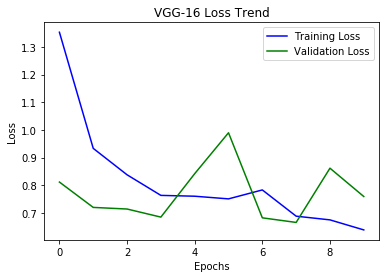

In [128]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()